# 混合高斯模型

1. 用混合了三个高斯的高斯模型去拟合三个高斯生成的数据

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

rng = np.random.default_rng(seed=123)

(array([ 2.,  1.,  4.,  7.,  9., 10., 22., 21., 22., 21., 16., 15., 17.,
        14., 13., 10.,  9.,  7.,  3.,  9.,  5.,  5., 13.,  9., 12., 12.,
         7.,  6.,  3.,  9., 11.,  2., 12., 21., 22., 39., 34., 28., 11.,
         7.]),
 array([-1.76496223, -1.46557558, -1.16618894, -0.8668023 , -0.56741566,
        -0.26802901,  0.03135763,  0.33074427,  0.63013091,  0.92951756,
         1.2289042 ,  1.52829084,  1.82767749,  2.12706413,  2.42645077,
         2.72583741,  3.02522406,  3.3246107 ,  3.62399734,  3.92338398,
         4.22277063,  4.52215727,  4.82154391,  5.12093055,  5.4203172 ,
         5.71970384,  6.01909048,  6.31847712,  6.61786377,  6.91725041,
         7.21663705,  7.5160237 ,  7.81541034,  8.11479698,  8.41418362,
         8.71357027,  9.01295691,  9.31234355,  9.61173019,  9.91111684,
        10.21050348]),
 <BarContainer object of 40 artists>)

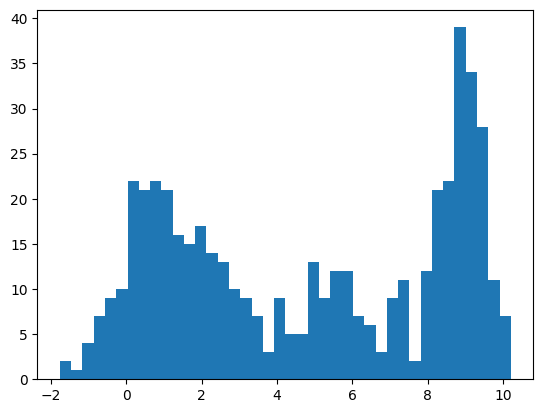

In [21]:
k = 3
ndata = 500
mu = np.array([1, 5, 9])
sigma = np.array([1, 2, 0.5])
idx = rng.integers(0, k, ndata)
x = rng.normal(mu[idx], sigma[idx], ndata)
plt.hist(x, 40)

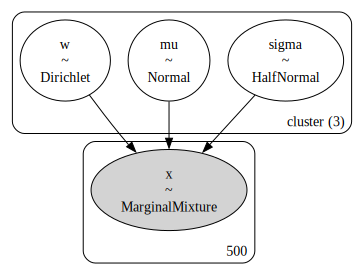

In [22]:
from traitlets import observe


with pm.Model(coords={"cluster": range(k)}) as model:
    mu = pm.Normal("mu", mu=0, sigma=5, dims="cluster")
    sigma = pm.HalfNormal("sigma", sigma=2, dims="cluster")
    coefficient = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=coefficient, mu=mu, sigma=sigma, observed=x)

pm.model_to_graphviz(model)

In [23]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

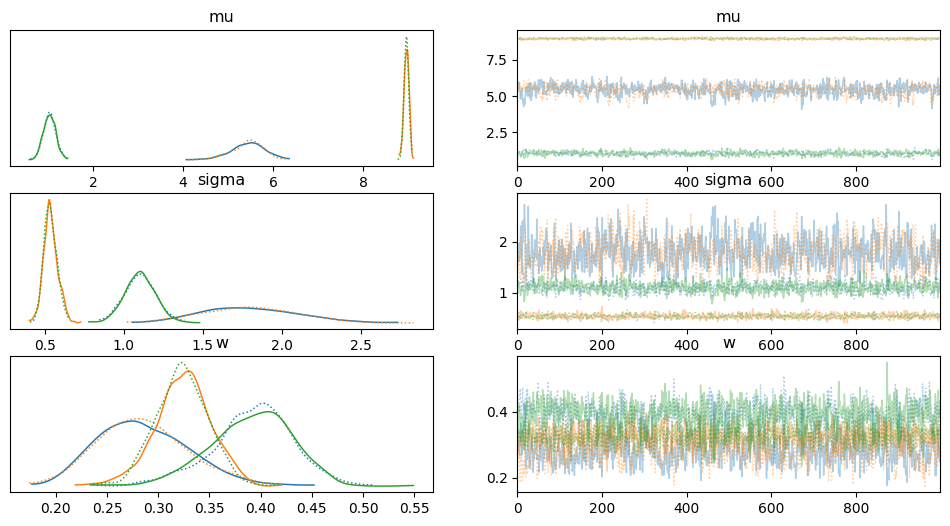

In [24]:
az.plot_trace(idata)

In [25]:
from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

In [ ]:
xi = np.linspace(0, 15, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["mu"], post["sigma"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

[Text(0.5, 1.0, 'PDF'), Text(0.5, 0, 'x'), Text(0, 0.5, 'Pro\ndensity')]

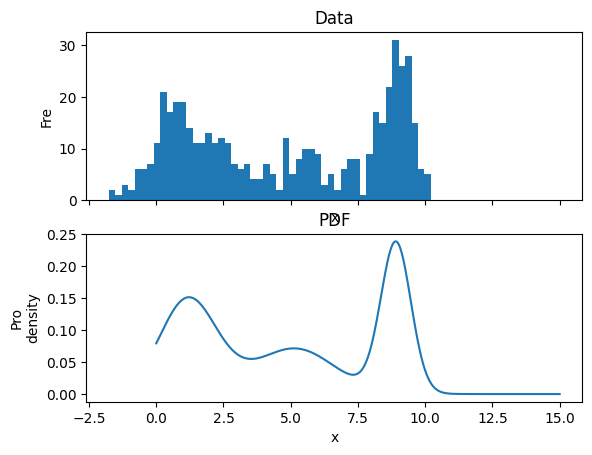

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].hist(x, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Fre")

pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Pro\ndensity")